<a href="https://colab.research.google.com/github/PriyanshuRao-code/AI-Lab-Project/blob/Armaan/team_24_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Don't do anything here. It's just a setup.
import os
import sys

repo_name = "AI-Lab-Project"
repo_url = "https://github.com/PriyanshuRao-code/AI-Lab-Project.git"
repo_path = f"/content/{repo_name}"

if os.path.exists(repo_path):
    print("Repository already exists at:", repo_path)
else:
    print("🚀 Cloning the repository...")
    os.system(f"git clone {repo_url}")

os.chdir(repo_path)
sys.path.append(repo_path)

print("Repository is ready to use at:", repo_path)

Repository already exists at: /content/AI-Lab-Project
Repository is ready to use at: /content/AI-Lab-Project


In [222]:
branch_name = "Armaan"

!git clone --branch {branch_name} --single-branch {repo_url}

fatal: destination path 'AI-Lab-Project' already exists and is not an empty directory.


In [223]:
# Start coding from here.

In [224]:
import pandas as pd
import numpy as np
import seaborn as sns

In [225]:
df = pd.read_csv('24.csv')

In [226]:
!pip install import-ipynb
import import_ipynb
from team_24_data_preprocessing import data_preprocessing
train, valid, test = data_preprocessing(df)

In [ ]:
df_numeric = df.select_dtypes(include=['number'])
df_non_numeric = df.select_dtypes(exclude=['number'])

In [ ]:
label_encoder = LabelEncoder()
for col in df_non_numeric.columns:
    df[col] = label_encoder.fit_transform(df[col])

In [ ]:
df.fillna(df.mean(), inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns
X_train_numeric = X_train.drop(columns=non_numeric_cols)
X_valid_numeric = X_valid.drop(columns=non_numeric_cols)
X_test_numeric = X_test.drop(columns=non_numeric_cols)

In [ ]:
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train_numeric)
X_valid_standard = scaler_standard.transform(X_valid_numeric)
X_test_standard = scaler_standard.transform(X_test_numeric)

In [ ]:
print("X_train shape:", X_train_standard.shape)
print("X_valid shape:", X_valid_standard.shape)
print("X_test shape:", X_test_standard.shape)

X_train shape: (3749, 35)
X_valid shape: (469, 35)
X_test shape: (469, 35)


In [ ]:
print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)
print("y_test shape:", y_test.shape)

y_train shape: (3749,)
y_valid shape: (469,)
y_test shape: (469,)


In [ ]:
print("\nMissing values in X_train:", np.isnan(X_train_standard).sum())
print("Missing values in y_train:", np.isnan(y_train).sum())


Missing values in X_train: 0
Missing values in y_train: 0


In [ ]:
print(f"\n Data Shapes: Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")


 Data Shapes: Train: (3749, 39), Valid: (469, 39), Test: (469, 39)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, 1)  # Single-layer NN
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.fc(x))

In [ ]:
X_train_tensor = torch.tensor(X_train_standard, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid_standard, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_standard, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy().reshape(-1, 1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.to_numpy().reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy().reshape(-1, 1), dtype=torch.float32)

In [ ]:
input_dim = X_train_standard.shape[1]
perceptron = Perceptron(input_dim)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(perceptron.parameters(), lr=0.01)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = perceptron(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.5626801252365112
Epoch 10, Loss: 0.5526069402694702
Epoch 20, Loss: 0.543168842792511
Epoch 30, Loss: 0.5342798829078674
Epoch 40, Loss: 0.5258744359016418
Epoch 50, Loss: 0.5179010033607483
Epoch 60, Loss: 0.5103185176849365
Epoch 70, Loss: 0.5030930042266846
Epoch 80, Loss: 0.4961962401866913
Epoch 90, Loss: 0.48960423469543457


In [ ]:
with torch.no_grad():
    y_valid_pred_nn = perceptron(X_valid_tensor).round()
    y_test_pred_nn = perceptron(X_test_tensor).round()

In [ ]:
y_valid_pred_nn = y_valid_pred_nn.numpy()
y_test_pred_nn = y_test_pred_nn.numpy()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [ ]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\nEvaluation Metrics for {model_name}:")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=["Not Hazardous", "Hazardous"], yticklabels=["Not Hazardous", "Hazardous"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    # Performance Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")

    return accuracy, precision, recall, f1

In [ ]:
y_valid_pred_nn = perceptron(X_valid_tensor).detach().numpy()
y_valid_pred_nn = (y_valid_pred_nn > 0.5).astype(int)


In [ ]:
X_test_tensor = torch.tensor(X_test_standard, dtype=torch.float32)
y_test_pred_nn = perceptron(X_test_tensor).detach().numpy()
y_test_pred_nn = (y_test_pred_nn > 0.5).astype(int)


Evaluation Metrics for Perceptron (Validation):


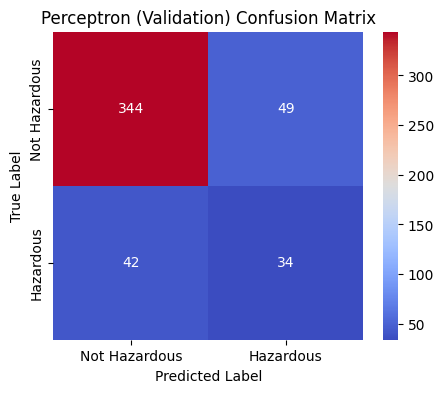


  Accuracy:  0.8060
  Precision: 0.4096
  Recall:    0.4474
  F1-score:  0.4277

Evaluation Metrics for Perceptron (Test):


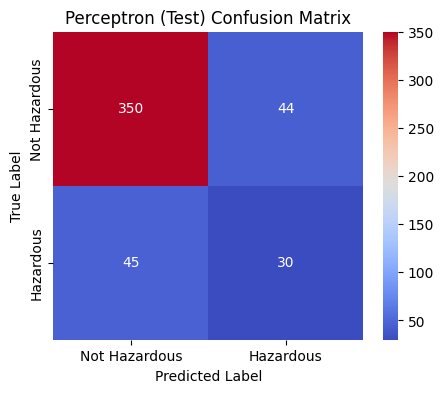


  Accuracy:  0.8102
  Precision: 0.4054
  Recall:    0.4000
  F1-score:  0.4027


(0.8102345415778252, 0.40540540540540543, 0.4, 0.40268456375838924)

In [ ]:
evaluate_model(y_valid, y_valid_pred_nn, "Perceptron (Validation)")
evaluate_model(y_test, y_test_pred_nn, "Perceptron (Test)")

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
X_train_nb = np.array(X_train_standard)
X_valid_nb = np.array(X_valid_standard)
X_test_nb = np.array(X_test_standard)

In [ ]:
y_train_nb = np.array(y_train)
y_valid_nb = np.array(y_valid)
y_test_nb = np.array(y_test)

In [ ]:
naiveBayes = GaussianNB()

In [ ]:
naiveBayes.fit(X_train_nb, y_train_nb)

GaussianNB()

In [ ]:
y_valid_pred_nb = naiveBayes.predict(X_valid_nb)

In [ ]:
y_test_pred_nb = naiveBayes.predict(X_test_nb)


Evaluation Metrics for Naïve Bayes (Validation):


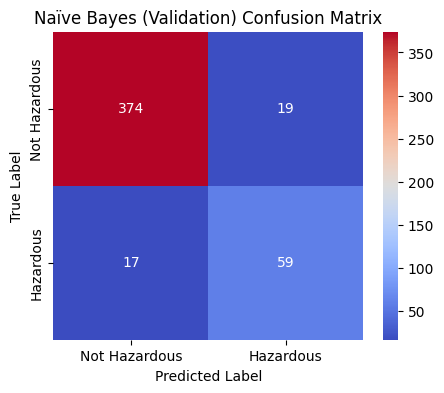


  Accuracy:  0.9232
  Precision: 0.7564
  Recall:    0.7763
  F1-score:  0.7662

Evaluation Metrics for Naïve Bayes (Test):


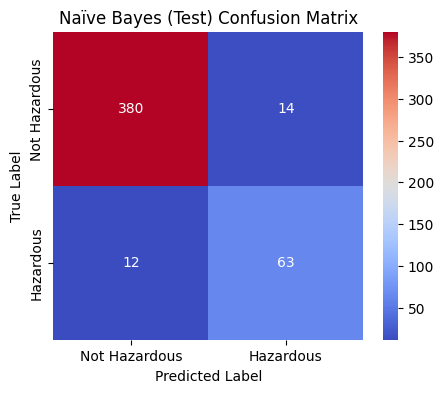


  Accuracy:  0.9446
  Precision: 0.8182
  Recall:    0.8400
  F1-score:  0.8289


(0.9445628997867804, 0.8181818181818182, 0.84, 0.8289473684210527)

In [ ]:
evaluate_model(y_valid_nb, y_valid_pred_nb, "Naïve Bayes (Validation)")
evaluate_model(y_test_nb, y_test_pred_nb, "Naïve Bayes (Test)")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X_train_knn = np.array(X_train_standard)
X_valid_knn = np.array(X_valid_standard)
X_test_knn = np.array(X_test_standard)

In [ ]:
y_train_knn = np.array(y_train)
y_valid_knn = np.array(y_valid)
y_test_knn = np.array(y_test)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [ ]:
def mahalanobis_distance(x, data, inv_cov_matrix):
  diff = data - x
  left = np.dot(diff, inv_cov_matrix)
  mahal_dist = np.sqrt(np.sum(left * diff, axis=1))
  return mahal_dist

In [ ]:
from collections import Counter

In [ ]:
def knn_mahalanobis(X_train, y_train, X_test, K):
   inv_cov_matrix = np.linalg.inv(np.cov(X_train.T))
   y_pred = []

   for x in X_test:
        distances = mahalanobis_distance(x, X_train, inv_cov_matrix)
        k_nearest_indices = np.argsort(distances)[:K]
        k_nearest_labels = y_train[k_nearest_indices]
        most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]
        y_pred.append(most_common_label)


   return np.array(y_pred)

In [ ]:
k_values = [1, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]
def find_best_k(X_train, y_train, X_valid, y_valid, k_values):
    accuracies = []

    for k in k_values:
     y_valid_pred = knn_mahalanobis(X_train, y_train, X_valid, K)
     acc = accuracy_score(y_valid, y_valid_pred)
     accuracies.append(acc)
     print(f" K={K} | Accuracy={acc:.4f}")
     best_k = k_values[np.argmax(accuracies)]
     print(f"\n Best K = {best_k} with Accuracy = {max(accuracies):.4f}")

     return best_k

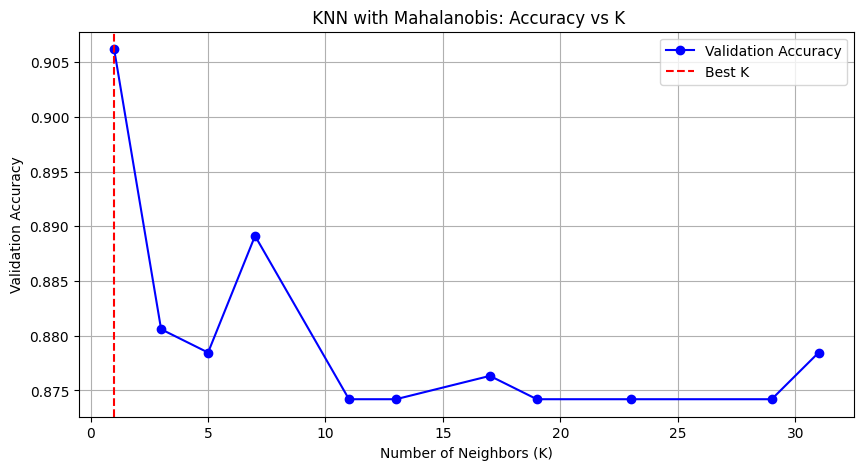

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue', label="Validation Accuracy")
plt.axvline(x=k_values[accuracies.index(max(accuracies))], color='red', linestyle='--', label="Best K")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Validation Accuracy")
plt.title(" KNN with Mahalanobis: Accuracy vs K")
plt.legend()
plt.grid()
plt.show()

In [ ]:
cov_matrix = np.cov(X_train_knn.T)

In [ ]:
inv_cov_matrix = np.linalg.pinv(cov_matrix)

In [ ]:
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric="mahalanobis", metric_params={"VI": inv_cov_matrix})
knn_final.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(metric='mahalanobis',
                     metric_params={'VI': array([[ 6.00679327e-01,  6.00679327e-01, -2.89201159e-01, ...,
        -1.91190538e-02,  1.01234269e-02,  1.32387504e+00],
       [ 6.00679327e-01,  6.00679327e-01, -2.89201159e-01, ...,
        -1.91190538e-02,  1.01234269e-02,  1.32387504e+00],
       [-2.89201159e-01, -2.89201159e-01,  4.48023147e+00, ...,
         9.91783730e-02,  2.53627544e-02, -7.99047690e+00],
       ...,
       [-1.91190538e-02, -1.91190538e-02,  9.91783730e-02, ...,
         2.78019473e+01, -2.50540638e+00, -3.34877495e+00],
       [ 1.01234269e-02,  1.01234269e-02,  2.53627544e-02, ...,
        -2.50540638e+00,  1.23789348e+00,  1.33074759e-01],
       [ 1.32387504e+00,  1.32387504e+00, -7.99047690e+00, ...,
        -3.34877495e+00,  1.33074759e-01,  8.30447715e+02]])},
                     n_neighbors=1)

In [ ]:
y_valid_pred_knn = knn_final.predict(X_valid_knn)

In [ ]:
y_test_pred_knn = knn_final.predict(X_test_knn)


Evaluation Metrics for KNN with Mahalanobis (Validation):


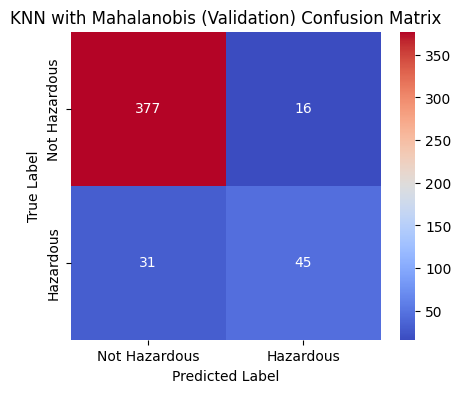


  Accuracy:  0.8998
  Precision: 0.7377
  Recall:    0.5921
  F1-score:  0.6569

Evaluation Metrics for KNN with Mahalanobis (Test):


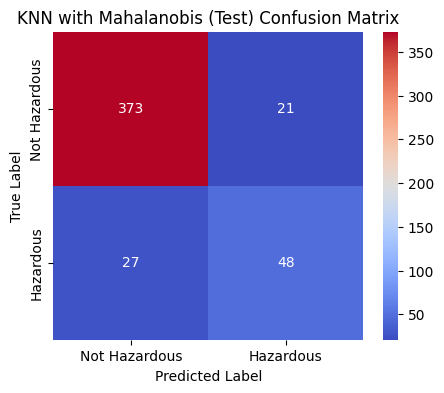


  Accuracy:  0.8977
  Precision: 0.6957
  Recall:    0.6400
  F1-score:  0.6667


(0.8976545842217484, 0.6956521739130435, 0.64, 0.6666666666666666)

In [ ]:
evaluate_model(y_valid, y_valid_pred_knn, "KNN with Mahalanobis (Validation)")
evaluate_model(y_test, y_test_pred_knn, "KNN with Mahalanobis (Test)")